In [2]:
from torch_snippets import *

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
device

'cuda'

In [5]:
from torchvision import datasets
import torch


In [6]:
data_folder = 'D:\datasets\colorization'

In [6]:
datasets.CIFAR10(data_folder, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting D:\datasets\colorization\cifar-10-python.tar.gz to D:\datasets\colorization


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: D:\datasets\colorization
    Split: Train

In [7]:
# define training and test datasets and data loaders
class Colorize(torchvision.datasets.CIFAR10):
    def __init__(self, root, train):
        super().__init__(root, train)

    def __getitem__(self, ix):
        im, _ = super().__getitem__(ix)
        bw = im.convert('L').convert('RGB')
        bw, im = np.array(bw)/255., np.array(im)/255.
        bw, im = [torch.tensor(i).permute(2,0,1).to(device).float() for i in [bw, im]]
        return bw, im

In [8]:
trn_ds = Colorize(data_folder, train=True)
val_ds = Colorize(data_folder, train=False)

In [9]:
trn_dl = DataLoader(trn_ds, batch_size=256, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=256, shuffle=False)

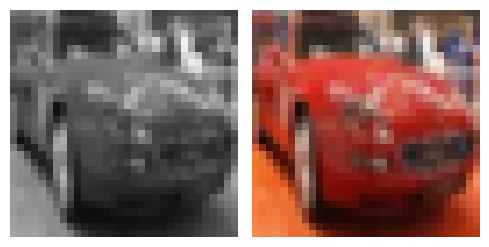

In [12]:
# plot input and output, actual size
a, b = trn_ds[5]
subplots([a, b], nc=2)

In [11]:
# define the network architecture
class Identity(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x

class DownConv(nn.Module):
    def __init__(self, ni, no, maxpool=True):
        super().__init__()
        self.model = nn.Sequential(
            nn.MaxPool2d(2) if maxpool else Identity(),
            nn.Conv2d(ni, no, 3, padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(no, no, 3, padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2, inplace=True),
        )
    def forward(self, x):
        return self.model(x)

class UpConv(nn.Module):
    def __init__(self, ni, no, maxpool=True):
        super().__init__()
        self.convtranspose = nn.ConvTranspose2d(ni, no, 2, stride=2)
        self.convlayers = nn.Sequential(
            nn.Conv2d(no+no, no, 3, padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(no, no, 3, padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
    def forward(self, x, y):
        x = self.convtranspose(x)
        x = torch.cat([x,y], axis=1)
        x = self.convlayers(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = DownConv( 3, 64, maxpool=False)
        self.d2 = DownConv( 64, 128)
        self.d3 = DownConv( 128, 256)
        self.d4 = DownConv( 256, 512)
        self.d5 = DownConv( 512, 1024)
        self.u5 = UpConv (1024, 512)
        self.u4 = UpConv ( 512, 256)
        self.u3 = UpConv ( 256, 128)
        self.u2 = UpConv ( 128, 64)
        self.u1 = nn.Conv2d(64, 3, kernel_size=1, stride=1)

    def forward(self, x):
        x0 = self.d1( x) # 32
        x1 = self.d2(x0) # 16
        x2 = self.d3(x1) # 8
        x3 = self.d4(x2) # 4
        x4 = self.d5(x3) # 2
        X4 = self.u5(x4, x3)# 4
        X3 = self.u4(X4, x2)# 8
        X2 = self.u3(X3, x1)# 16
        X1 = self.u2(X2, x0)# 32
        X0 = self.u1(X1) # 3
        return X0


In [13]:
# define model, optimizer and loss function
def get_model():
    model = UNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()
    return model, optimizer, loss_fn

In [14]:
# functions to train and validate the model
def train_batch(model, data, optimizer, criterion):
    model.train()
    x, y = data
    _y = model(x)
    optimizer.zero_grad()
    loss = criterion(_y, y)
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    x, y = data
    _y = model(x)
    loss = criterion(_y, y)
    return loss.item()


EPOCH: 5.000  trn_loss: 0.006  val_loss: 0.005  (159.62s - 670.40s remaining)
EPOCH: 10.000  trn_loss: 0.005  val_loss: 0.006  (318.88s - 510.21s remaining)
EPOCH: 15.000  trn_loss: 0.005  val_loss: 0.005  (478.60s - 350.97s remaining)
EPOCH: 20.000  trn_loss: 0.005  val_loss: 0.005  (635.68s - 190.70s remaining)
EPOCH: 25.000  trn_loss: 0.004  val_loss: 0.005  (796.11s - 31.84s remaining)
EPOCH: 25.245  trn_loss: 0.005  (803.04s - 24.02s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 25.255  trn_loss: 0.004  (803.33s - 23.69s remaining)

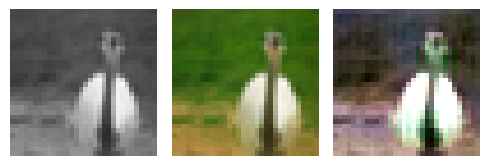

EPOCH: 25.500  trn_loss: 0.005  (810.25s - 15.89s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 25.510  trn_loss: 0.004  (810.54s - 15.56s remaining)

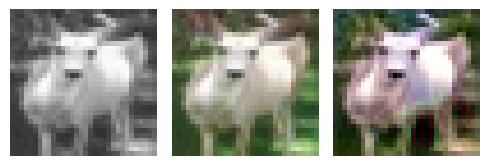

EPOCH: 25.755  trn_loss: 0.004  (817.50s - 7.77s remaining))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 25.765  trn_loss: 0.004  (817.79s - 7.45s remaining)

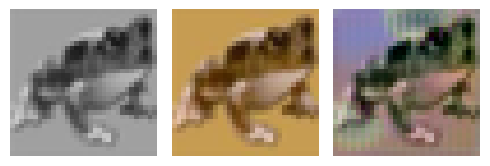

EPOCH: 25.925  val_loss: 0.004  (827.76s - 2.39s remaining))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 26.000  val_loss: 0.003  (827.95s - 0.00s remaining)

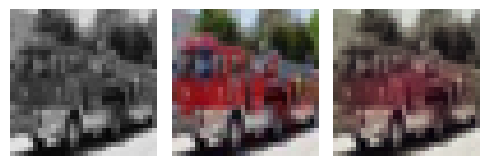

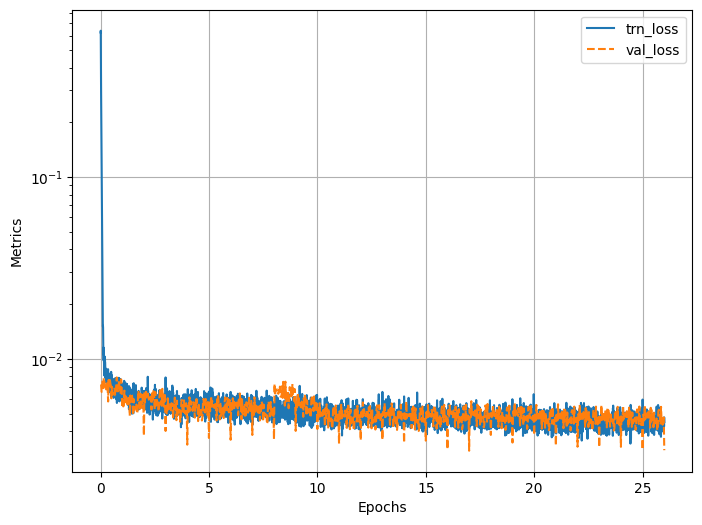

100%|██████████| 127/127 [00:00<00:00, 1298.49it/s]


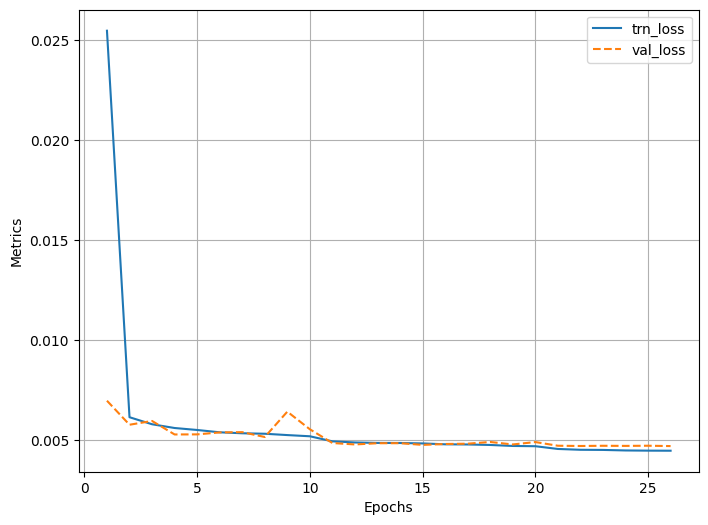

In [24]:
# train model
model, optimizer, criterion = get_model()
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

_val_dl = DataLoader(val_ds, batch_size=1, shuffle=True)

n_epochs = 26
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, end='\r')
        if (bx+1)%50 == 0:
            if ex in [25, 50, 75, 99]:
                for _ in range(1):
                    a,b = next(iter(_val_dl))
                    _b = model(a)
                    subplots([a[0], b[0], _b[0]], nc=3, figsize=(5,5))

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, end='\r')
        
    exp_lr_scheduler.step()
    if (ex+1) % 5 == 0: log.report_avgs(ex+1)
    if ex in [25, 50, 75, 99]:
        for _ in range(1):
            a,b = next(iter(_val_dl))
            _b = model(a)
            subplots([a[0], b[0], _b[0]], nc=3, figsize=(5,5))

log.plot(log=True)


log.plot_epochs()


